In [3]:
import sys
sys.path.append("../../")
from multiprocessing import Pool
import tqdm
import pickle
from pathlib import Path
from contextlib import closing
from rdkit import Chem
import numpy as np
import pandas as pd

# Load fragmentation results

In [6]:
%%time
fragments_path = Path("/net/cci/cschlick/Filtered_COD3/fragmentation_results.pkl")
with fragments_path.open("rb") as fh:
  fragmentation_results_all = pickle.load(fh)

CPU times: user 19.9 s, sys: 3.08 s, total: 23 s
Wall time: 23 s


In [5]:
N_max = 1000 # cut number of molecules
fragmentation_results = [fragmentation_results_all[i] for i in range(N_max)]
angle_fragments = []
bond_fragments = []
for i,fragmentation_result in enumerate(fragmentation_results):
  angle_fragments+=fragmentation_result["angle_fragments"]
  bond_fragments+=fragmentation_result["bond_fragments"]

## Explore a few fragments

In [7]:
frag = angle_fragments[20]

In [8]:
frag.properties

{'filepath': PosixPath('/net/cci/cschlick/Filtered_COD3/1/01/1100172/1100172.mol2'),
 'angle_deg': 109.75167543636009}

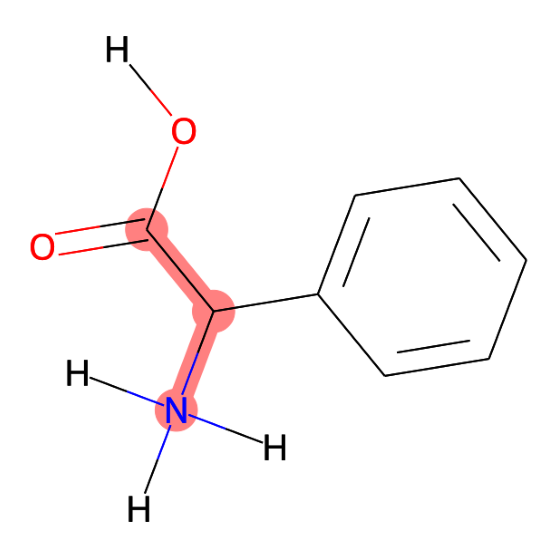

In [9]:
frag.show()

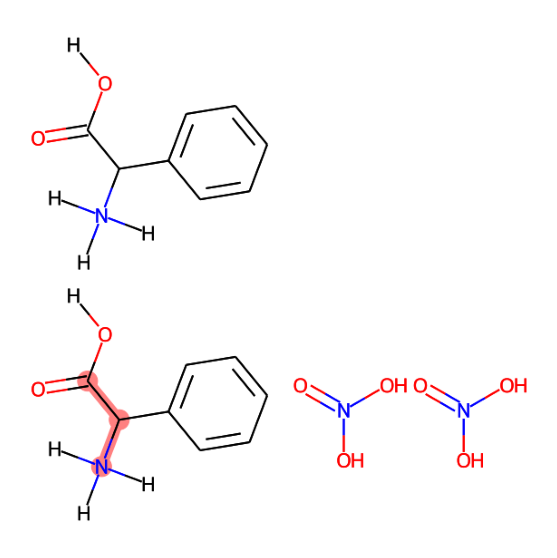

In [10]:
frag.show(only_connected=False)

## Featurize fragments

In [11]:
from phenixml.featurizers.ani_featurizer import ANIFeaturizer

In [12]:
# elements and parameters
covalent_organic = ["O","C","H","N","P","S","Cl","B","F","I","Br"]
metals = ["Na","K","Ca","Fe","Mn","Zn","Mg","Cu","Co"]

params = {'radial_cutoff': 4.6,
 'radial_nu': 32,
 'radial_probes': [0.7,
                  1.4,
                  1.9,
                  2.4,
                  3.2,
                  3.8,
                  4.4],
 'angular_cutoff': 3.1,
 'angular_nu': 4,
 'angular_probes': [0.0, 1.57, 3.14, 4.71],
 'angular_radial_probes': [0.7,1.4,1.9,2.4],
 'angular_zeta': 8,
 'min_probed_value': 0.0,
 'exclude_hydrogens': False,
 'elements_considered': covalent_organic}

In [13]:
mode = "angle"
if mode == "angle":
  fragment_key = "angle_fragments"
elif mode == "bond":
  fragment_key = "bond_fragments"

def worker(result):
  featurizer = ANIFeaturizer.from_bond_angle_frags(result[fragment_key],params)
  if featurizer is None:
    return None
  else:
    return featurizer.featurize()



In [17]:
work = fragmentation_results
with closing(Pool(processes=16)) as pool:
  features = []
  for result in tqdm.tqdm(pool.map(worker, work), total=len(work)):
      features.append(result)
  pool.terminate()

100%|██████████| 1000/1000 [00:00<00:00, 732501.57it/s]


In [20]:
X = []

for i,feature in enumerate(features):
  if feature is not None:
    bond_fragments+=fragmentation_results[i]["bond_fragments"]
    X.append(feature)
X = np.vstack(X)
print(X.shape)

(48090, 1133)


In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [22]:
mode = "bond"
if mode =="bond":

  y =  np.array([frag.properties["bond_length"] for frag in bond_fragments])
  space = np.arange(X.shape[0])
  train, test = train_test_split(space,test_size=0.2)
  frags_train, frags_test = [angle_fragments[i] for i in train], [angle_fragments[i] for i in test]
elif mode == "angle":
  X = angle_features
  y =  np.array([frag.properties["angle_deg"] for frag in angle_fragments])
  train, test = train_test_split(space,test_size=0.2)
  frags_train, frags_test = [angle_fragments[i] for i in train], [angle_fragments[i] for i in test]
  
X_train, X_test = X[train],X[test]
y_train, y_test = y[train],y[test]

In [25]:
regressor = RandomForestRegressor(n_estimators=100,min_samples_split=2, random_state=0,n_jobs=-1)

In [ ]:
%%time
regressor.fit(X_train,y_train)

In [25]:
y_pred = regressor.predict(X_test)

Text(0, 0.5, 'Predicted')

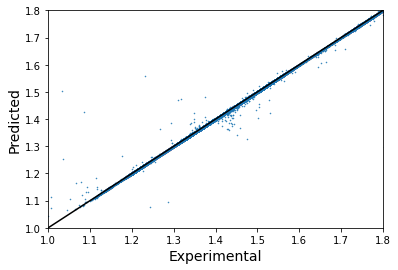

In [26]:
df = pd.DataFrame({"dists":y_test.flatten(),"pred":y_pred.flatten()})
ax = df.plot.scatter("dists","pred",s=0.25)
if mode == "bond":
  ax.set_xlim(1,1.8)
  ax.set_ylim(1,1.8)
elif mode == "angle":
  ax.set_xlim(50,140)
  ax.set_ylim(50,140)
ax.plot([0,200],[0,200],color="black")
ax.set_xlabel("Experimental",fontsize=14)
ax.set_ylabel("Predicted",fontsize=14)

In [ ]:
from sklearn.metrics import mean_squared_error
import seaborn as sns
residuals = y_test-y_pred
sns.histplot(residuals)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("RMSE:",rmse)